In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import cauchy, gamma

import emcee
print(emcee.__version__)

import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Categorical, Normal

2.2.1


### Data

We generate 1 million samples from the Gaussian distribution with the model parameters:

1. <b>delta</b> ~ cauchy(0, 1)
2. <b>mu</b> ~ cauchy(0, 1)
3. <b>sigma</b> ~ gamma(2, 2)
4. <b>alpha</b> = delta * sigma
5. <b>x</b> ~ normal(mu+alpha, sigma)
6. <b>y</b> ~ normal(mu, sigma)

In [93]:
num_points = 10000

In [94]:
def generate_data_normal(N):
    
    delta = np.random.standard_cauchy(1)
    mu = np.random.standard_cauchy(1)
    sigma = np.random.gamma(2, 2, 1)
    alpha = delta * sigma
    
    xdata = np.random.normal(mu+alpha, sigma, N)
    ydata = np.random.normal(mu, sigma, N)
    return (xdata, ydata)

In [95]:
def plot_points(x, y):
    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ok', markersize=3)
    plt.grid()
    plt.show()

In [96]:
def plot_hist(x, y):
    plt.figure(figsize=(10,5))
    plt.hist(x, alpha=0.5, bins=500, label="X data")
    plt.hist(y, alpha=0.5, bins=500, label="Y data")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

def plot_trace_hist(trace):
    plt.hist(trace, alpha=0.5, bins=500, label="delta")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

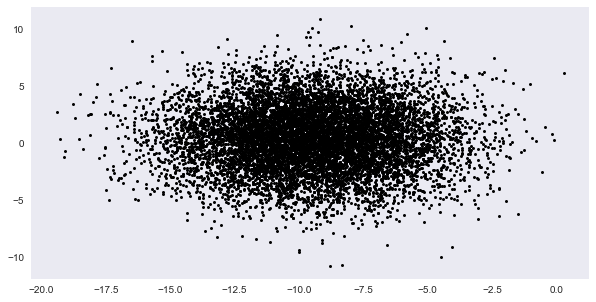

In [97]:
np.random.seed(42)
xdata, ydata = generate_data_normal(num_points)
plot_points(xdata, ydata)

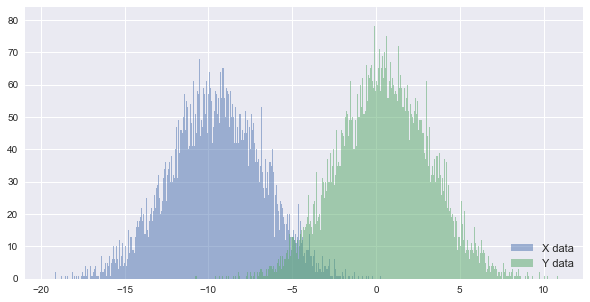

In [98]:
plot_hist(xdata, ydata)

Further we will investigate sampling package [Emcee](https://github.com/dfm/emcee) and variational inference using [Edward](https://github.com/blei-lab/edward) package.

### Emcee sampler

In [99]:
_xdata = np.array(xdata, dtype=float)
_ydata = np.array(ydata, dtype=float)

assert(all(np.isnan(_xdata)) == False)
assert(all(np.isnan(_ydata)) == False)

In [169]:
def lnprior(theta):
    delta, mu, sigma, alpha = theta
    
    prob_delta = cauchy.pdf(delta, 0, 1)
    prob_mu = cauchy.pdf(mu, 0, 1)

    prob_sigma = gamma.pdf(sigma, 2, 2)
    alpha = prob_delta * prob_sigma
    
    if prob_sigma <= 0:
        return -np.inf
    else:
        return np.log(prob_delta) + np.log(prob_mu) + np.log(prob_sigma)
    
    
def lnlike(theta, x, y):
    delta, mu, sigma, alpha = theta
    
    log_coeff = np.log( 1 / np.sqrt(2 * np.pi * sigma**2) )
    denom = 2 * (sigma ** 2)
    x_g = ( (x - (mu + alpha))**2 ) / denom
    y_g = ( (y - mu)**2 ) / denom
                
    return (2 * log_coeff) - x_g - y_g 

def lnposterior(theta, x, y):
    return lnprior(theta) + lnlike(theta, x, y)

In [177]:
ndim = 4  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [185]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=[xdata, ydata])
%time pos = sampler.run_mcmc(starting_guesses, nsteps)
print("done")

/Users/ddedik/anaconda2/envs/py3k/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ddedik/anaconda2/envs/py3k/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


CPU times: user 1min 7s, sys: 321 ms, total: 1min 7s
Wall time: 1min 8s
done


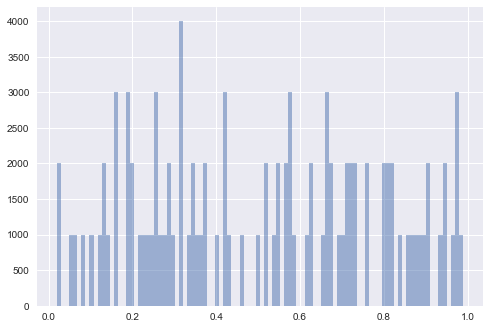

In [189]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plt.hist(emcee_trace[0], alpha=0.5, bins=100, label="delta")
plt.show()

### Variational inference with Edward